# autocovariance estimation

There are several possible estimates for the autocovariance:

$
\begin{align}
\hat \sigma^\ast(\tau) &= \frac{1}{N(\tau)} \sum [u(t+\tau) - \hat\mu] [u(t)-\hat\mu], \\
\hat \sigma(\tau) &= \frac{1}{N} \sum [u(t+\tau) - \hat\mu] [u(t)-\hat\mu], \\
\hat \sigma^\ast_\mu(\tau) &= \frac{1}{N(\tau)} \sum [u(t+\tau) - \mu] [u(t)-\mu], \\
\hat \sigma_\mu (\tau) &= \frac{1}{N} \sum [u(t+\tau) - \mu] [u(t)-\mu],
\end{align}
$

where $N(\tau)$ is the number of points used to estimate the autocovariance for lag $\tau$ and $N$ is the length of the timeseries. \
The first two estimates, $\hat \sigma^\ast(\tau)$ and $\hat \sigma(\tau)$, are the only ones computable in practice.

### bias of the correlation estimates

$\hat \sigma ^\ast$ and $\hat \sigma_\mu ^\ast$ are in general called the **unbiased estimates** of the covariance even though $\hat \sigma ^\ast$ is only asymptotically biased.
The bias can be substantial for small dataset as illustrated below and similar to the variance bias (expected as variance is covariance at lag 0).
See Priestley eq. (5.3.12) for an estimate of this bias:

$
\begin{align}
\langle \hat \sigma^\ast(\tau) \rangle &= \sigma(\tau) - Var(\mu), \\
&= \sigma(\tau) - \frac{\sigma_0}{N_e}
\end{align}
$

$\hat \sigma$ and $\hat \sigma_\mu$ are the **biased estimates**.
The amplitude of the bias depends on lag (Priestley eq (5.3.15)).
These estimates are favoured in general as they exhibit less variance for larger lags (see illustrations below and discussion p323 of Priestley).
Their bias increases with lag and is of the order of (Priestley 5.3.14):

$
\begin{align}
\langle \hat \sigma(\tau) \rangle &= - \frac{\tau /dt}{N} \sigma(\tau)
\end{align}
$



### variance of correlation estimates

Variance of correlation estimates involve in general fourth order moments (Priestley 5.3.21). \
Assuming Gaussianity substantially simplifies the variance expression (Priestley 5.3.23 to 5.3.25).

$
\begin{align}
var(\hat \sigma_\mu)(\tau) = 
\frac{1}{N} \sum_{m=-(N-\tau)+1}^{N-\tau-1} 
\Big \{  1. - \frac{|m|+\tau}{N} \Big \} 
\big [ \sigma^2(m) + \sigma(m+r) \sigma(m-r) \big ], \\
var(\hat \sigma)(\tau) = 
\frac{1}{N-\tau} \sum_{m=-(N-\tau)+1}^{N-\tau-1} 
\Big \{  1. - \frac{|m|+\tau}{N} \Big \} 
\big [ \sigma^2(m) + \sigma(m+r) \sigma(m-r) \big ],
\end{align}
$

Note that these estimates assumes the mean is $\mu$ is known a priori.
These results originate from Barlett 1946.

https://github.com/statsmodels/statsmodels/blob/159d8dd62e1911e4fd36d1a05269b88cea5e9e56/statsmodels/tsa/stattools.py#L683

### mean square errors

Bias and variance are combined (generic relationships for all statistical estimates):
    
$
\begin{align}
MSE(\sigma) &= \langle (\hat \sigma - \sigma)^2 \rangle, \\
&= \langle (\hat \sigma - \langle \hat \sigma \rangle + \langle \hat \sigma \rangle - \sigma)^2 \rangle, \\
&= \langle (\hat \sigma - \langle \hat \sigma \rangle)^2 \rangle
+
(\langle \hat \sigma \rangle - \sigma)^2, \\
&= Var(\hat \sigma) + Bias^2(\hat \sigma)
\end{align}
$

### references:
- [Priestley](https://www.google.com/search?q=10.1111%2F2041-210X.12176) (chapter 5):  Spectral analysis and timeseries

---

### substracting the estimated mean: bias

All estimates (including so-called "biased" and "unbiased" ones) are in fact biased.

We show also the spread which illustrates the increase spread at large lags.

In [1]:
import xarray as xr
import numpy as np

#from numpy.linalg import inv, slogdet
#from scipy.optimize import minimize
#from scipy.stats import chi2
from scipy import stats                                                         

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

#import skgstat as skg
#from pprint import pprint

import sstats.tseries as ts
import sstats.sigp as sigp

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#ts.exp_autocorr?

In [3]:
mu=0 # true mean
sigma0 = 1 # true variance
T = 10 # days, decorrelation timescale

delta_T = 100 # time series length
dt = 3/24 # sampling interval in days

sigma_true = lambda tau: sigma0*np.exp(-abs(tau)/T)

In [4]:
u = mu + ts.exp_autocorr((delta_T, dt), T, 
                         np.sqrt(sigma0), 
                         #burnin=int(10*T/dt),
                         draws=1000, 
                         seed=0,
                        ).compute()

## derived parameters:

# total number of points
N = u.time.size # = delta_T/dt 

# AR parameter used in approximated formulas
a = np.exp(-dt/T)

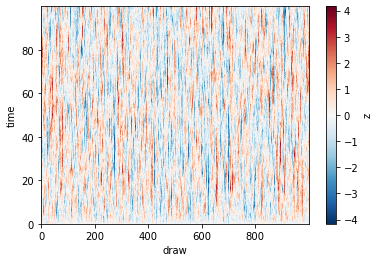

In [5]:
#dt=3 # hours
#u = ts.exp_autocorr((1000, dt/24), 10, 1, seed=0).compute()
u.plot()

**Compute basic statistical estimates**

The distribution of the sample mean is pretty wide owing to the strong autocorrelation of the data

In [6]:
ds = u.mean("time").rename("mu_hat").to_dataset()

mean_Ne, sigma0_Ne, sigma0_scale = sigp.effective_DOF(sigma_true, dt, N)
print(mean_Ne, sigma0_Ne, sigma0_scale)

# we anticipate the correction factor associate with the autocorrelation and small (effective) sample size
ds["sigma0_hat"] = u.var("time")*sigma0_scale

5.555439123081167 10.525709874446227 1.2179934083773847


In [7]:
def show_dist(pdf, ax, label="theoretical pdf", color="k", **kwargs):
    #stats.norm.pdf, loc=mu, scale=sigma0/np.sqrt(Neff)
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = pdf(x_pdf, **kwargs)
    ax.plot(x_pdf, y_pdf, color=color, lw=2, label=label)

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


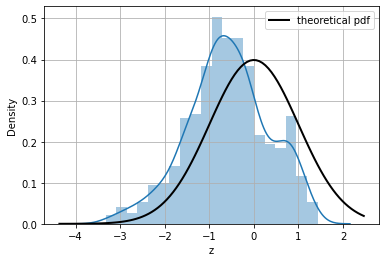

In [8]:
ax = sns.distplot(u.isel(draw=0), bins=20, norm_hist=True)
show_dist(stats.norm.pdf, ax, label="theoretical pdf", color="k", loc=mu, scale=np.sqrt(sigma0))
ax.grid()
ax.legend()

In [9]:
# with subsampling:
#stats.kstest?

In [10]:
def plot_sigma(ds, label="sigma_hat"):
    fig, ax = plt.subplots(1,1, figsize=(10,5))

    ds["sigma_true"].plot(ax=ax, label="truth")

    c_biased = "k"
    ds[label].quantile(0.05, "draw").plot(ax=ax, color=c_biased, label="biased")
    ds[label].quantile(0.95, "draw").plot(ax=ax, color=c_biased)

    c_unbiased = "cadetblue"
    ds[label+"_unbiased"].quantile(0.05, "draw").plot(ax=ax, color=c_unbiased, label="unbiased")
    ds[label+"_unbiased"].quantile(0.95, "draw").plot(ax=ax, color=c_unbiased)

    ds[label].mean("draw").plot(color=c_biased, ) #label="mean"
    ds[label+"_unbiased"].mean("draw").plot(color=c_unbiased, ) #label="mean unbiased"

    ax.legend()

    ax.grid()

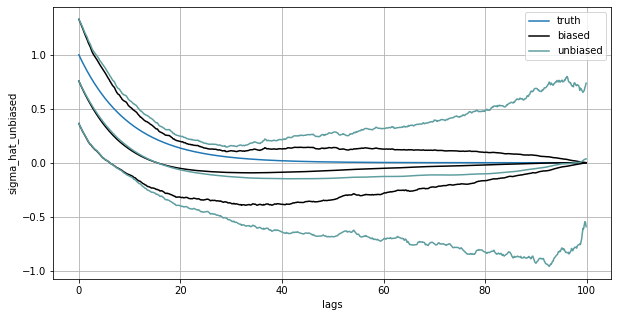

In [11]:
up = (u - ds["mu_hat"]).rename("u_p")

ds["sigma_hat"] = sigp.correlate(up, up)
ds["sigma_hat_unbiased"] = sigp.correlate(up, up, biased=False)

ds["sigma_true"] = sigma_true(ds.lags)

plot_sigma(ds)

### substracting the true (unknown) mean

The unbiased estimates is indeed unbiased. \
The biased estimate is indeed biased but the biias is relatively small.

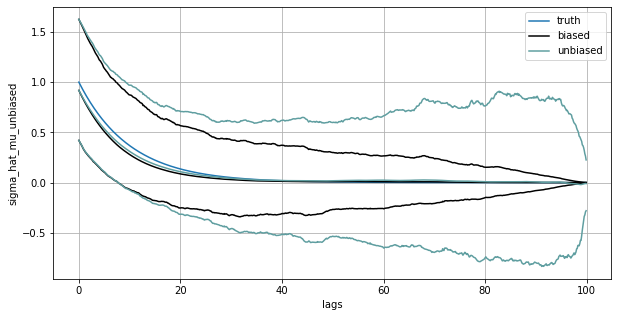

In [12]:
up = (u - mu).rename("u_p")

ds["sigma_hat_mu"] = sigp.correlate(up, up)
ds["sigma_hat_mu_unbiased"] = sigp.correlate(up, up, biased=False)

plot_sigma(ds, label="sigma_hat_mu")

### variance of the estimate

We compare next the observed variance of the variance estimate and compare it with the theoretical one estimated from autocoriance estimates as well as true autocovariances.

For small sample size (as here, i.e. 5 effective points), the observed variance is substantially smaller than theoretical predictions.

In [13]:
# estimate of the variance with the estimated auto-covariance (but with true mu)
ds["sigma_hat_var_predicted"] = sigp.barlett(ds.sigma_hat_mu, "lags")
ds["sigma_hat_unbiased_var_predicted"] = sigp.barlett(ds.sigma_hat_mu_unbiased, "lags")

# estimate of the variance with the true auto-covariance
ds["sigma_hat_var_predicted_true"] = sigp.barlett(ds.sigma_true, "lags")

**biased covariance estimate:**

Text(0.5, 1.0, 'variance of the biased covariance estimate')

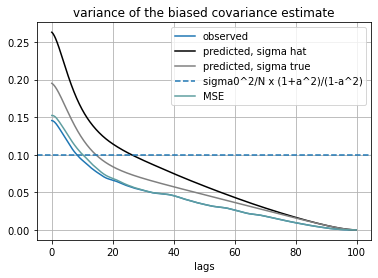

In [15]:
fig, ax = plt.subplots(1,1)

# observed variance
ds["sigma_hat_mu"].var("draw").plot(label="observed")

# theoretical variance
(ds["sigma_hat_var_predicted"]).mean("draw").plot(color="k", label="predicted, sigma hat")
ds["sigma_hat_var_predicted_true"].plot(color="0.5", label="predicted, sigma true")

# AR_variance prediction
AR_variance = sigma0**2/N * (1+a**2)/(1-a**2)
ax.axhline(AR_variance, ls="--", label="sigma0^2/N x (1+a^2)/(1-a^2)")

# MSE
MSE = ((ds["sigma_hat_mu"] - ds["sigma_true"])**2).mean("draw")
MSE.plot(label="MSE", color="cadetblue") # MSE not variance !!

ax.legend()
ax.grid()
ax.set_title("variance of the biased covariance estimate")

Using the variance estimate $\hat \sigma$ produces a variance that is twice larger than the actual one and this overestimations seems to be persist when the sample size is increased. \
Using the true variance does also produce an estimate that is about 30% too large compared to the actual one but this overestimation decreases when the sample size is increased.

As a side note, the mean square error is entirely driven by the variance of the estimate here.

**unbiased covariance estimate:**

Text(0.5, 1.0, 'variance of the unbiased covariance estimate')

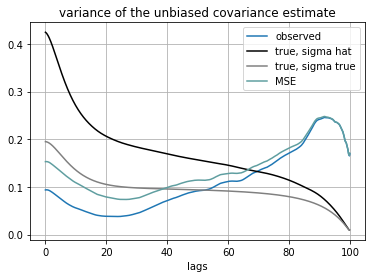

In [15]:
fig, ax = plt.subplots(1,1)

# observed variance
ds["sigma_hat_unbiased"].var("draw").plot(label="observed")

# theoretical variance
scale = max(ds.lags)/(max(ds.lags) - ds.lags)
(scale*ds["sigma_hat_unbiased_var_predicted"]).mean("draw").plot(color="k", label="true, sigma hat")
(scale*ds["sigma_hat_var_predicted_true"]).plot(color="0.5", label="true, sigma true")

MSE = ((ds["sigma_hat_unbiased"] - ds["sigma_true"])**2).mean("draw")
MSE.plot(label="MSE", color="cadetblue") # MSE not variance !!

ax.legend()
ax.grid()
ax.set_title("variance of the unbiased covariance estimate")

The variance is again overestimated with worst overestimation with the sampled autocovariance (which is what would be used in practice remember). \
The variance that would be used in practice (black line) is larger than for the unbiased estimate.

The increase of the variance (and mean square error) with lags is larger than theoretical expectations.\
Is this due to truncations in Barlett formulas ?

As seen from the difference between MSE and the observed variance the bias is substantial (le comble pour un estimateur soit-disant "unbiased") and largest at small lags.

Text(0.5, 1.0, 'mean square error')

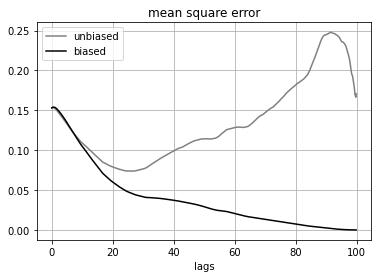

In [16]:
fig, ax = plt.subplots(1,1)

# unbiased
MSE = ((ds["sigma_hat_unbiased"] - ds["sigma_true"])**2).mean("draw")
MSE.plot(label="unbiased", color="0.5") # MSE not variance !!

# biased
MSE = ((ds["sigma_hat"] - ds["sigma_true"])**2).mean("draw")
MSE.plot(label="biased", color="k") # MSE not variance !!

ax.legend()
ax.grid()
ax.set_title("mean square error")

### distribution

Select one lag, show & compare with theory

Priestley 5.3.5: "We remarked previously that, for finite N, the distribtuion theory of the sample autocovariances and autocorrelations is extremely complicated. This is particularly so for the sample autocorrelations ..."

Distributions of $\sqrt{N} [\hat \sigma(\tau) - \sigma(\tau)]$ are *asymptotically joint normal* with zero mean and covariance given by Priestley 5.3.24 (more or less above formulas ; for Gaussian processes otherwise more general forms of covariances)


In [18]:
def show_dist(pdf, ax, label="theoretical pdf", color="k", **kwargs):
    #stats.norm.pdf, loc=mu, scale=sigma0/np.sqrt(Neff)
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = pdf(x_pdf, **kwargs)
    ax.plot(x_pdf, y_pdf, color=color, lw=2, label=label)

**Lag 0**:

Variance look about right but there seems to be a bias here but it is not (too much) the case, the distribution is just skewed toward negative values.

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


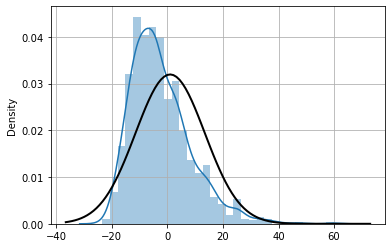

In [34]:
_ds = ds.sel(lags=0)
ax = sns.distplot(np.sqrt(N)*(_ds.sigma_hat_mu - _ds.sigma_true), bins=30, norm_hist=True)

show_dist(stats.norm.pdf, ax, label="theoretical pdf", color="k", 
          loc=float(_ds.sigma_true), 
          scale=np.sqrt(float(_ds.sigma_hat_var_predicted_true)*N),
         )

ax.grid()

In [35]:
np.sqrt(N)*float(_ds.sigma_hat_mu.mean())

25.957282642642486

In [36]:
np.sqrt(N)*float(_ds.sigma_true)

28.284271247461902

**Lag T**:

Variance look about right but there seems to be a bias here but it is not (too much)  the case, the distribution is just skewed toward negative values.

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


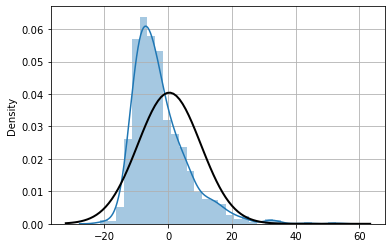

In [31]:
_ds = ds.sel(lags=T)
ax = sns.distplot(np.sqrt(N)*(_ds.sigma_hat_mu-_ds.sigma_true), bins=30, norm_hist=True)

show_dist(stats.norm.pdf, ax, label="theoretical pdf", color="k", 
          loc=float(_ds.sigma_true), 
          scale=np.sqrt(float(_ds.sigma_hat_var_predicted_true)*N),
         )

ax.grid()

In [32]:
np.sqrt(N)*float(_ds.sigma_hat_mu.mean())

7.899194889137864

In [33]:
np.sqrt(N)*float(_ds.sigma_true)

10.40520190045778

**Lag 5T**:

Variance is a bit overestimated, consistent with previous observations

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


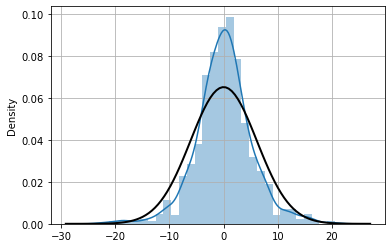

In [25]:
_ds = ds.sel(lags=5*T)
ax = sns.distplot(np.sqrt(N)*(_ds.sigma_hat_mu-_ds.sigma_true), bins=30, norm_hist=True)

show_dist(stats.norm.pdf, ax, label="theoretical pdf", color="k", 
          loc=float(_ds.sigma_true), 
          scale=np.sqrt(float(_ds.sigma_hat_var_predicted_true)*N),
         )

ax.grid()

--- 
## sensitivity to sample size

wraps all estimation to show 

In [23]:

def experiment(delta_T):
    """ wraps all analysis in a single method as a function of timeseries length (delta_T)
    """

    u = mu + ts.exp_autocorr((delta_T, dt), T, 
                             np.sqrt(sigma0), 
                             #burnin=int(10*T/dt),
                             draws=1000, 
                             seed=0,
                            ).compute()

    # total number of points
    N = u.time.size # = delta_T/dt 
    
    ds = u.mean("time").rename("mu_hat").to_dataset()

    mean_Ne, sigma0_Ne, sigma0_scale = sigp.effective_DOF(sigma_true, dt, N)
    print(f"N effective (mean) = {mean_Ne:.1f}")

    # we anticipate the correction factor associate with the autocorrelation and small (effective) sample size
    ds["sigma0_hat"] = u.var("time")*sigma0_scale
    
    # with estimated mean
    up = (u - ds["mu_hat"]).rename("u_p")
    ds["sigma_hat"] = sigp.correlate(up, up)
    ds["sigma_hat_unbiased"] = sigp.correlate(up, up, biased=False)
    ds["sigma_true"] = sigma_true(ds.lags)

    # with true mean
    up = (u - mu).rename("u_p")
    ds["sigma_hat_mu"] = sigp.correlate(up, up)
    ds["sigma_hat_mu_unbiased"] = sigp.correlate(up, up, biased=False)
    
    # predictions of the variance with the estimated auto-covariance (but with true mu)
    ds["sigma_hat_var_predicted"] = sigp.barlett(ds.sigma_hat_mu, "lags").mean("draw")
    ds["sigma_hat_unbiased_var_predicted"] = sigp.barlett(ds.sigma_hat_mu_unbiased, "lags").mean("draw")

    # prediction of the variance with the true auto-covariance
    ds["sigma_hat_var_predicted_true"] = sigp.barlett(ds.sigma_true, "lags")
    
    # observed variance
    ds["sigma_hat_var_observed"] = ds["sigma_hat_mu"].var("draw")
    ds["sigma_hat_unbiased_var_observed"] = ds["sigma_hat_mu_unbiased"].var("draw")
    
    # mean square errors
    ds["sigma_hat_mse"] = ((ds["sigma_hat_mu"] - ds["sigma_true"])**2).mean("draw")
    ds["sigma_hat_unbiased_mse"] = ((ds["sigma_hat_mu_unbiased"] - ds["sigma_true"])**2).mean("draw")

    return ds

N effective (mean) = 20.5


400 days long time series (x4 samples)

In [ ]:
ds = experiment(400)

Text(0.5, 1.0, 'variance of the biased covariance estimate')

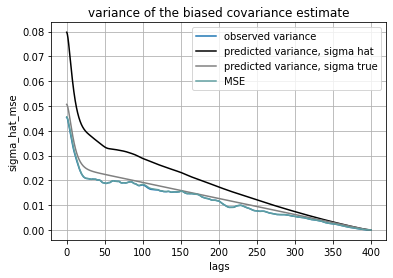

In [24]:
fig, ax = plt.subplots(1,1)

# observed variance
ds["sigma_hat_var_observed"].plot(label="observed variance")

# theoretical variance
(ds["sigma_hat_var_predicted"]).plot(color="k", label="predicted variance, sigma hat")
ds["sigma_hat_var_predicted_true"].plot(color="0.5", label="predicted variance, sigma true")

ds["sigma_hat_mse"].plot(label="MSE", color="cadetblue")

ax.legend()
ax.grid()
ax.set_title("variance of the biased covariance estimate")